In [177]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import scipy

from twython import Twython

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score

from IPython.display import clear_output

import plotly.express as px

import matplotlib.pyplot as plt
import seaborn as sns

from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vladimirkulichenko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vladimirkulichenko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data

In [3]:
df = pd.read_csv('tweets_ml_predicted.csv')

In [4]:
df.sample(3)

,Unnamed: 0,id,id_str,created_at,full_text,name,screen_name,location,followers_count,geo,place,retweet_count,favorite_count,operation_attitude,text_clean,text_tokenized,opinion_prediction
10778,10778,1522361073038290944,1522361073038290944,Thu May 05 23:42:18 +0000 2022,@KhalilovaGulsum Ура! россия!,26F7,JackieW57864724,NaN,15,NaN,NoData,0,0,0.0,ура россия,"['ур', 'росс']",1.0
10208,10208,1522349463674761218,1522349463674761218,Thu May 05 22:56:10 +0000 2022,"RT @underground1973: Ох, Киев взял в заложники...",AndreiGurgurov,AndreiGurgurov1,NaN,120,NaN,NoData,3,0,NaN,"ох, киев взял в заложники бабушку аню с харько...","['ох', 'ки', 'взял', 'заложник', 'бабушк', 'ан...",1.0
9564,9564,1522120899821981698,1522120899821981698,Thu May 05 07:47:56 +0000 2022,@gudkov_g @manstremus А чё в 14 на Донбас напа...,Akira,gavazovna,Finland,52,NaN,NoData,0,0,NaN,а чё в на донбас напали безоруженные?,"['че', 'донбас', 'напа', 'безоружен']",0.0


# Location

In this section we will map contry to each location for the tweets, where there is any actual information about the country

In [179]:
def clear_location_country(x):
    '''
    Function sets country, based on what is written in location.
    '''
    try:
        if 'MOSC' in x or 'МОСК' in x or 'ПЕТЕРБУРГ' in x or 'PIETROBURGO' in x \
                       or 'SMOLENSK' in x or 'RUSSIA' in x or 'РОСТОВ' in x \
                       or 'УФА' in x or 'РОССИЯ' in x or 'ОМСК' in x \
                       or 'ЧЕЛЯБИНСК' in x or 'РЯЗАНЬ' in x or 'СМОЛЕНСК' in x \
                       or 'КАЛУГА' in x or 'ТУЛА' in x or 'САМАРА' in x \
                       or 'НОВОСИБИРСК' in x or 'КЕМЕРОВО' in x or 'ROSTOV-ON' in x \
                       or 'КРАСНОЯРСК' in x or 'ОРЕНБУРГ' in x or 'МУРМАНСК' in x \
                       or 'КАМЧАТСКИЙ' in x or 'ПЯТИГОРСК' in x or 'ЕКАТЕРИНБ' in x\
                       or 'МАЛАХОВКА' in x or 'САРАТОВ' in x or 'КРАСНОДАР' in x \
                       or 'ПЕНЗА' in x or 'ПЕРМЬ' in x or 'ДАГЕСТАН' in x or 'СИБИРЬ' in x \
                       or 'РОССИЙ' in x or 'TAGIL' in x or 'ЗЕЛЕНОГРАД' in x \
                       or 'SAINT PETERBURG' in x or 'РУССКАЯ' in x or 'СЕВАСТОПОЛЬ' in x \
                       or 'САМАРСКИЙ' in x or 'TATARSTAN' in x or 'КАЛИНИНГРАД' in x \
                       or 'СОЧИ' in x or 'МСК' in x or 'БЕЛГОРОДСКАЯ' in x \
                       or 'РОСТОВ-НА-ДОНУ' in x or 'С ПБ' in x or 'СПБ' in x \
                       or 'KALININGRAD' in x:
            return 'Russia'
        
        if 'УКРАИНА' in x or 'UCRAINA' in x or 'UKRAINE' in x or 'УКРАЇНА' in x \
                           or 'КИЕВ' in x or 'KYIV' in x or 'ХАРЬКОВ' in x \
                           or 'КИЇВ' in x or 'ДОНЕЦК' in x or 'МАРИУПОЛЬ' in x \
                           or 'ОДЕССА' in x or 'ЧОРНОБАЇВКА' in x or 'ДОНБАСС' in x \
                           or 'МИКОЛАЇВ' in x or 'ЛУГАНСК' in x or 'CHERNIVTSI' in x:
            return 'Ukraine'
        
        if 'БЕЛАРУСЬ' in x or 'МИНСК' in x or 'MINSK' in x:
            return 'Belarus'
        
        if 'KAZAKHSTAN' in x or 'АЛМАТЫ' in x or 'КАЗАХСТАН' in x:
            return 'Kazakhstan'
        
        if 'DEUTSCHLAND' in x or 'ГЕРМАНИ' in x or 'SASSONIA' in x or 'GERMANY' in x \
                                or 'KÖNIGSBERG' in x:
            return 'Germany'
        
        if 'UNITED STATES' in x or 'USA' in x or 'NEW YORK' in x or 'BOSTON' in x \
                                or 'AMARILLO' in x or 'MIAMI' in x or 'DALLAS' in x \
                                or 'NY' in x or 'LOS ANGELES' in x or 'RESTON' in x \
                                or 'SHELTON' in x or 'SAN RAFAEL' in x or 'PHOENIX' in x \
                                or 'MASSACHUSETTS' in x or 'PHILADELPHIA' in x \
                                or 'НЬЮ-ЙОРК' in x or 'GREENWOOD, IN' in x:
            return 'United States'
        
        if 'ITALIA' in x:
            return 'Italy'
        
        if 'ESTONIA' in x:
            return 'Estonia'
        
        if 'LATVIA' in x or 'LATVIJA' in x or 'RĪGA' in x:
            return 'Latvia'
        
        if 'ТБИЛИСИ' in x or 'GEORGIA' in x or 'TBILISI' in x:
            return 'Georgia'
        
        if 'SWITZERLAND' in x:
            return 'Switzerland'
        
        if 'КАНАДА' in x or 'ONTARIO' in x:
            return 'Canada'
        
        if 'BARCELON' in x or 'SPAIN' in x or 'ESPAN' in x:
            return 'Spain'
        
        if 'LONDON' in x or 'ЛОНДОН' in x or 'DUBLIN' in x or 'WALES' in x \
                         or 'UNITED KINGDOM' in x:
            return 'United Kingdom'
        
        if 'SUOMI' in x or 'FINLAND' in x:
            return 'Finland'
        
        if 'ИЗРАИЛЬ' in x or 'ISRAEL' in x:
            return 'Israel'
        
        if 'WARSZAWA' in x or 'POLAND' in x or 'POLSKA' in x:
            return 'Poland'
        
        if 'INDIA' in x:
            return 'India'
        
        if 'MONGOLIA' in x:
            return 'Mongolia'
        
        if 'TÜRKİYE' in x:
            return 'Turkey'
        
        if 'SLOVENIJA' in x:
            return 'Slovenia'
        
        if 'PRAHA' in x or 'PRAGUE' in x:
            return 'Czech Republic'
        
        if 'PARIS' in x or 'FRANCE' in x:
            return 'France'
        
        if 'AUSTRALIA' in x:
            return 'Australia'
        
        if 'LUXEMBOURG' in x:
            return 'Luxembourg'
        
        if 'GÖTEBORG' in x or 'STOCKHOLM' in x:
            return 'Sweden'
        
        if 'AZERBAIJAN' in x:
            return 'Azerbaijan'
        
        if 'JAPAN' in x:
            return 'Japan'
        
        if 'ЛИТВА' in x:
            return 'Lithuania'
        
        if 'SERBIA' in x or 'BATAJNICA' in x:
            return 'Serbia'
        
        if 'THAILAND' in x:
            return 'Thailand'
        
        if 'MOROCCO' in x:
            return 'Morocco'
        
        if 'БОЛГАРИЯ' in x:
            return 'Bulgaria'
        
        if 'GREECE' in x:
            return 'Greece'
        
        if 'ELVERUM, NORGE' in x:
            return 'Norway'
        
        else:
            return x
    except:
        return 'NO DATA'

In [81]:
df['location'] = df['location'].str.upper()

df['country'] = [clear_location_country(x) for x in df['location']]

# Sentiment analysis

We are using pre-trained FastText model from Dostoevsky library that has achieved high scores on RuSentiment dataset.

In [5]:
tokenizer = RegexTokenizer()

model = FastTextSocialNetworkModel(tokenizer=tokenizer)

Predicting probabily of each emotion

In [34]:
df['sentiment_positive'] = [model.predict([x])[0]['positive'] for x in df['text_clean']]
df['sentiment_nagative'] = [model.predict([x])[0]['negative'] for x in df['text_clean']]
df['sentiment_neutral'] = [model.predict([x])[0]['neutral'] for x in df['text_clean']]
df['sentiment_skip'] = [model.predict([x])[0]['skip'] for x in df['text_clean']]
df['sentiment_speech'] = [model.predict([x])[0]['speech'] for x in df['text_clean']]

In [18]:
df[['text_clean','sentiment_positive', 'sentiment_nagative', 'sentiment_neutral',
    'sentiment_skip', 'sentiment_speech']].sample(5)

,text_clean,sentiment_positive,sentiment_nagative,sentiment_neutral,sentiment_skip,sentiment_speech
1747,"что вислоухий, тебя тоже поставили в не ловко...",0.003493,0.484390,0.692652,0.092698,0.032111
2073,украинские военные не подтверждают бэнкет в хе...,0.071601,0.629785,0.239359,0.067557,0.001377
11560,кроме онлайн камер люблю гулять по гугл картам...,0.098089,0.136618,0.507822,0.119213,0.001511
5239,в екатеринбурге у храма-на крови — на месте до...,0.065615,0.103759,0.515630,0.250923,0.003955
5366,а вы как думаете?ж/д состав с гуманитарным гру...,0.007587,0.355785,0.651365,0.160276,0.011697


Changing probability to value with specific threshholds

In [35]:
df['sentiment_positive'] = np.where(df['sentiment_positive'] > 0.5, 1, 0)
df['sentiment_nagative'] = np.where(df['sentiment_nagative'] > 0.5, 1, 0)
df['sentiment_neutral'] = np.where(df['sentiment_neutral'] > 0.5, 1, 0)
df['sentiment_skip'] = np.where(df['sentiment_skip'] > 0.4, 1, 0)

In [40]:
mask = df['sentiment_skip'] != 1

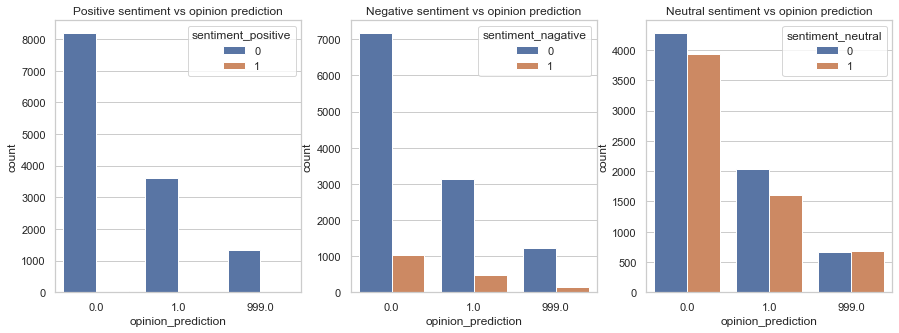

In [52]:
f, axes = plt.subplots(1, 3, figsize=(15,5))

sns.countplot(x="opinion_prediction", hue="sentiment_positive", data=df[mask], ax=axes[0])
sns.countplot(x="opinion_prediction", hue="sentiment_nagative", data=df[mask], ax=axes[1])
sns.countplot(x="opinion_prediction", hue="sentiment_neutral", data=df[mask], ax=axes[2])

axes[0].set_title('Positive sentiment vs opinion prediction')
axes[1].set_title('Negative sentiment vs opinion prediction')
axes[2].set_title('Neutral sentiment vs opinion prediction')

plt.show()

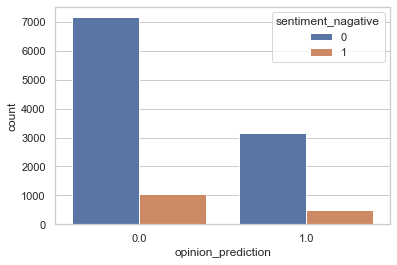

In [150]:
sns.countplot(x="opinion_prediction", hue="sentiment_nagative", 
              data=df[mask & (df['opinion_prediction'] != 999)])
plt.show()

# Hypothesis testing

In this part we are testing statistical hypothesis

Functions to use to test the hypothesis

In [145]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [97]:
countries_no_russia = ['United States', 'United Kingdom', 'Mongolia',
             'Belarus', 'Poland', 'Germany', 'Kazakhstan', 'Canada', 'India', 
             'India', 'Latvia', 'Finland', 'France', 'Turkey', 'Czech Republic',
             'Israel', 'Japan', 'Australia', 'Slovenia', 'Italy', 'Georgia', 'Switzerland',
             'Estonia', 'Sweden', 'Luxembourg', 'Azerbaijan', 'Spain', 'Thailand',
             'Serbia', 'Lithuania', 'Morocco', 'Bulgaria', 'Greece', ]#'Norway']

Data samples information for each of the hypothesis

In [101]:
# Hypothesis 1

opinion_0 = df.loc[df['opinion_prediction'] == 0, 'sentiment_nagative']
opinion_1 = df.loc[df['opinion_prediction'] == 1, 'sentiment_nagative']

print('------------------------------------------------------')
print(f'For hypothesis 1 we have the following data samples:')
print('------------------------------------------------------')
print(f'{len(opinion_0)} support Ukraine and {sum(opinion_0)} of those have posted \
a tweet with a negative emotion.')
print(f'Percentage of negative tweets is {100*round(sum(opinion_0)/len(opinion_0), 3)}%')
print('')
print(f'{len(opinion_1)} support Russia and {sum(opinion_1)} of those have posted \
a tweet with a negative emotion.')
print(f'Percentage of negative tweets is {100*round(sum(opinion_1)/len(opinion_1), 4)}%')
print('')

# Hypothesis 2

russia_opinion = df.loc[(df['country'].isin(['Russia', 'Belarus'])) & \
                        (df['opinion_prediction'].isin([0,1])), 'opinion_prediction']
other_countries_opinion = df.loc[(df['country'].isin(countries_no_russia)) & \
                        (df['opinion_prediction'].isin([0,1])), 'opinion_prediction']

print('______________________________________________________')
print('------------------------------------------------------')
print(f'For hypothesis 2 we have the following data samples:')
print('------------------------------------------------------')
print(f'{len(russia_opinion)} tweets from Russia or Belarus')
print(f'{sum(russia_opinion)} of them support Russia')
print(f'Percentage of support is {100*round(sum(russia_opinion)/len(russia_opinion), 2)}%')
print('')
print(f'{len(other_countries_opinion)} tweets outside Russia or Belarus')
print(f'{sum(other_countries_opinion)} of them support Russia')
print(f'Percentage of support is {100*round(sum(other_countries_opinion)/len(other_countries_opinion), 2)}%')
print('')

# Hypothesis 3

russian_negative = df.loc[(df['country'].isin(['Russia', 'Belarus'])), 'sentiment_nagative']
other_negative = df.loc[(df['country'].isin(countries_no_russia)), 'sentiment_nagative']

print('______________________________________________________')
print('------------------------------------------------------')
print(f'For hypothesis 3 we have the following data samples:')
print('------------------------------------------------------')
print(f'{len(russian_negative)} tweets from Russia or Belarus')
print(f'{sum(russian_negative)} of them are negative')
print(f'Percentage of negative tweets is {100*round(sum(russian_negative)/len(russian_negative), 4)}%')
print('')
print(f'{len(other_negative)} tweets outside Russia or Belarus')
print(f'{sum(other_negative)} of them are negative')
print(f'Percentage of negative tweets is {100*round(sum(other_negative)/len(other_negative), 4)}%')
print('')

------------------------------------------------------
For hypothesis 1 we have the following data samples:
------------------------------------------------------
8985 support Ukraine and 1152 of those have posted a tweet with a negative emotion.
Percentage of negative tweets is 12.8%

3797 support Russia and 536 of those have posted a tweet with a negative emotion.
Percentage of negative tweets is 14.12%

______________________________________________________
------------------------------------------------------
For hypothesis 2 we have the following data samples:
------------------------------------------------------
1779 tweets from Russia or Belarus
538.0 of them support Russia
Percentage of support is 30.0%

982 tweets outside Russia or Belarus
257.0 of them support Russia
Percentage of support is 26.0%

______________________________________________________
------------------------------------------------------
For hypothesis 3 we have the following data samples:
---------------

In [146]:
# H1
print("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(opinion_0, opinion_1))

print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(opinion_0, opinion_1)))

95% confidence interval for a difference between proportions: [-0.026006, 0.000105]
p-value: 0.048132


In [154]:
# H2
print("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(russia_opinion, other_countries_opinion))

print("p-value: %f" % \
      proportions_diff_z_test(proportions_diff_z_stat_ind(russia_opinion, 
                                                          other_countries_opinion),
                             ))

95% confidence interval for a difference between proportions: [0.005901, 0.075511]
p-value: 0.023739


In [165]:
# H3
print("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(russian_negative, other_negative))

print("p-value: %f" % \
      proportions_diff_z_test(proportions_diff_z_stat_ind(russian_negative, 
                                                          other_negative),
                             ))

95% confidence interval for a difference between proportions: [0.000549, 0.047122]
p-value: 0.050893


# Country visualization

In [172]:
countries = ['Russia', 'Ukraine', 'United States', 'United Kingdom', 'Mongolia',
             'Belarus', 'Poland', 'Germany', 'Kazakhstan', 'Canada', 'India', 
             'India', 'Latvia', 'Finland', 'France', 'Turkey', 'Czech Republic',
             'Israel', 'Japan', 'Australia', 'Slovenia', 'Italy', 'Georgia', 'Switzerland',
             'Estonia', 'Luxembourg', 'Azerbaijan', 'Spain', 'Thailand',
             'Serbia', 'Lithuania', 'Morocco', 'Bulgaria', 'Greece', ]#'Norway', 'Sweden']

## Russia support

Visualizing contries, that support Russia

In [173]:
mask_countries = df['country'].isin(countries)
mask_prediction = df['opinion_prediction'].isin([0,1])

df_countries = df.loc[mask_countries & mask_prediction].groupby('country').agg({
            'opinion_prediction' : ['sum', 'count']}).reset_index()

df_countries.columns = ['country', 'sum', 'count']

df_countries['russian_support_proportion'] = df_countries['sum']/df_countries['count']

gapminder = px.data.gapminder().query("year==2007")

df_countries = pd.merge(df_countries,
                        gapminder[['country', 'iso_alpha']],
                        on='country',
                        how='left')

df_countries.loc[df_countries['country'] == 'Azerbaijan', 'iso_alpha'] = 'AZE'
df_countries.loc[df_countries['country'] == 'Belarus', 'iso_alpha'] = 'BLR'
df_countries.loc[df_countries['country'] == 'Estonia', 'iso_alpha'] = 'EST'
df_countries.loc[df_countries['country'] == 'Georgia', 'iso_alpha'] = 'GEO'
df_countries.loc[df_countries['country'] == 'Kazakhstan', 'iso_alpha'] = 'KAZ'
df_countries.loc[df_countries['country'] == 'Latvia', 'iso_alpha'] = 'LVA'
df_countries.loc[df_countries['country'] == 'Luxembourg', 'iso_alpha'] = 'LUX'
df_countries.loc[df_countries['country'] == 'Russia', 'iso_alpha'] = 'RUS'
df_countries.loc[df_countries['country'] == 'Ukraine', 'iso_alpha'] = 'UKR'
df_countries.loc[df_countries['country'] == 'Lithuania', 'iso_alpha'] = 'LTU'

In [174]:
df_countries.sample(5)

,country,sum,count,russian_support_proportion,iso_alpha
15,Japan,7.0,20,0.350000,JPN
12,India,6.0,36,0.166667,IND
5,Czech Republic,8.0,22,0.363636,CZE
27,Switzerland,1.0,3,0.333333,CHE
25,Slovenia,3.0,13,0.230769,SVN


In [175]:
fig = px.choropleth(df_countries, 
                    locations="iso_alpha",
                    color="russian_support_proportion", 
                    hover_name="country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)

fig.show()

## Sentiment negative

Visualizing negative emotion tweets

In [169]:
mask_countries = df['country'].isin(countries)
#mask_prediction = df['opinion_prediction'].isin([0,1])

df_countries = df.loc[mask_countries].groupby('country').agg({
            'sentiment_nagative' : ['sum', 'count']}).reset_index()

df_countries.columns = ['country', 'sum', 'count']

df_countries['negative_proportion'] = df_countries['sum']/df_countries['count']

gapminder = px.data.gapminder().query("year==2007")

df_countries = pd.merge(df_countries,
                        gapminder[['country', 'iso_alpha']],
                        on='country',
                        how='left')

df_countries.loc[df_countries['country'] == 'Azerbaijan', 'iso_alpha'] = 'AZE'
df_countries.loc[df_countries['country'] == 'Belarus', 'iso_alpha'] = 'BLR'
df_countries.loc[df_countries['country'] == 'Estonia', 'iso_alpha'] = 'EST'
df_countries.loc[df_countries['country'] == 'Georgia', 'iso_alpha'] = 'GEO'
df_countries.loc[df_countries['country'] == 'Kazakhstan', 'iso_alpha'] = 'KAZ'
df_countries.loc[df_countries['country'] == 'Latvia', 'iso_alpha'] = 'LVA'
df_countries.loc[df_countries['country'] == 'Luxembourg', 'iso_alpha'] = 'LUX'
df_countries.loc[df_countries['country'] == 'Russia', 'iso_alpha'] = 'RUS'
df_countries.loc[df_countries['country'] == 'Ukraine', 'iso_alpha'] = 'UKR'
df_countries.loc[df_countries['country'] == 'Lithuania', 'iso_alpha'] = 'LTU'

In [171]:
df_countries.sample(5)

,country,sum,count,negative_proportion,iso_alpha
23,Russia,245,1904,0.128676,RUS
30,Ukraine,181,1415,0.127915,UKR
32,United States,31,254,0.122047,USA
20,Mongolia,2,75,0.026667,MNG
1,Azerbaijan,0,11,0.000000,AZE


In [170]:
fig = px.choropleth(df_countries, 
                    locations="iso_alpha",
                    color="negative_proportion", 
                    hover_name="country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)

fig.show()

# Word Cloud

Word cloud for each of the opinion 

In [178]:
russian_stop_words = stopwords.words("russian")
def tokenize_text(x):
    tokens = word_tokenize(x, language='russian')
    tokens_no_punkt = [i for i in tokens if i not in string.punctuation]
    tokens_no_stopwords = [i for i in tokens_no_punkt if i not in russian_stop_words]
    #stemmed_tokens = [snowball.stem(i) for i in tokens_no_stopwords]
    return tokens_no_stopwords

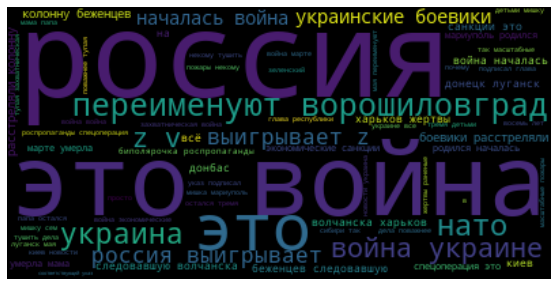

In [130]:
text = ' '.join([' '.join(x) for x in [tokenize_text(x) for x \
                                       in df.loc[df['opinion_prediction'] == 1, 'text_clean']]])

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

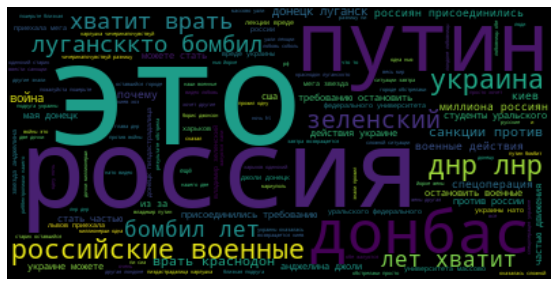

In [131]:
text = ' '.join([' '.join(x) for x in [tokenize_text(x) for x \
                                       in df.loc[df['opinion_prediction'] == 0, 'text_clean']]])

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()